ROI Analysis

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# Helper Functions
def partial_eta_squared(aov):
    """Calculate partial eta-squared for ANOVA results."""
    aov = aov.copy()
    aov['pes'] = (aov['Num DF'] * aov['F Value']) / (aov['Num DF'] * aov['F Value'] + aov['Den DF'])
    return aov

def analyze_roi_data(data, experiment='exp1'):
    """Analyze ROI data with multiple comparison correction."""
    results = {}
    all_tests = []
    
    if experiment == 'exp1':
        conditions = ['object', 'scramble']
        rois = ['LO', 'pIPS']
    else:
        conditions = ['tool', 'nontool']
        rois = ['PFS', 'aIPS', 'LO', 'pIPS']
        
    for roi in rois:
        for hemi in ['left', 'right']:
            roi_data = data[(data['roi'] == roi) & (data['hemi'] == hemi)]
            cond1_data = roi_data[roi_data['cond'] == conditions[0]]['mean_act'].values
            cond2_data = roi_data[roi_data['cond'] == conditions[1]]['mean_act'].values
            
            # Calculate statistics
            t_stat, p_val = ttest_rel(cond1_data, cond2_data)
            mean_diff = np.mean(cond1_data - cond2_data)
            se_diff = np.std(cond1_data - cond2_data) / np.sqrt(len(cond1_data))
            d = mean_diff / np.sqrt((np.std(cond1_data)**2 + np.std(cond2_data)**2) / 2)
            
            # Store results
            all_tests.append({
                'roi': f'{hemi}_{roi}',
                'p_value': p_val,
                't_stat': t_stat,
                'mean_diff': mean_diff,
                'se': se_diff,
                'cohens_d': d,
                'n': len(cond1_data),
                f'mean_{conditions[0]}': np.mean(cond1_data),
                f'mean_{conditions[1]}': np.mean(cond2_data)
            })
    
    # Apply Holm-Bonferroni correction
    p_values = [test['p_value'] for test in all_tests]
    _, p_corrected, _, _ = multipletests(p_values, method='holm')
    
    # Update results with corrected p-values
    for test, p_corr in zip(all_tests, p_corrected):
        results[test['roi']] = test
        results[test['roi']]['p_corrected'] = p_corr
    
    return results

def run_rmanova(data, factors):
    """Run repeated measures ANOVA with effect sizes."""
    aov = AnovaRM(data=data, 
                  depvar='mean_act',
                  subject='sub',
                  within=factors).fit()
    
    aov_table = partial_eta_squared(aov.anova_table)
    return aov_table

In [9]:
# Load Data
# Experiment 1
exp1_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/selectivity/selectivity_summary.csv")

filtered_exp1 = exp1_results[(exp1_results['group'] == 'control') & 
                            (exp1_results['roi'].isin(['LO', 'pIPS'])) &
                            (exp1_results['sub'] != 'sub-084')]

# Experiment 2
exp2_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/tools/selectivity/selectivity_summarytoolloc.csv")
filtered_exp2 = exp2_results[exp2_results['sub'].str.contains('spaceloc')]

In [13]:
# Experiment 1 ROI Analysis
# Full ANOVA
exp1_anova = run_rmanova(filtered_exp1, ['roi', 'hemi', 'cond'])
print("Experiment 1 ANOVA Results:")
print(exp1_anova)

# ROI Analysis
exp1_roi_results = analyze_roi_data(filtered_exp1, 'exp1')
print("\nExperiment 1 ROI Results:")
for roi, stats in exp1_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")

Experiment 1 ANOVA Results:
                  F Value  Num DF  Den DF        Pr > F       pes
roi             39.763898     1.0    17.0  7.897722e-06  0.700514
hemi            10.301246     1.0    17.0  5.140748e-03  0.377318
cond            55.387486     1.0    17.0  9.623988e-07  0.765153
roi:hemi         2.803147     1.0    17.0  1.123766e-01  0.141551
roi:cond       108.745714     1.0    17.0  8.346158e-09  0.864807
hemi:cond        2.746805     1.0    17.0  1.157867e-01  0.139101
roi:hemi:cond    0.056390     1.0    17.0  8.151334e-01  0.003306

Experiment 1 ROI Results:

left_LO:
t(17) = 8.141, p = 0.0000, p_corr = 0.0000
Cohen's d = 2.474
Mean difference = 2.526 ± 0.301

right_LO:
t(17) = 8.303, p = 0.0000, p_corr = 0.0000
Cohen's d = 2.689
Mean difference = 2.314 ± 0.271

left_pIPS:
t(17) = 3.815, p = 0.0014, p_corr = 0.0028
Cohen's d = 1.233
Mean difference = 0.851 ± 0.217

right_pIPS:
t(17) = 2.760, p = 0.0134, p_corr = 0.0134
Cohen's d = 0.947
Mean difference = 0.549 ± 0.193

In [15]:
# Experiment 2 ROI Analysis
# Full ANOVA
exp2_anova = run_rmanova(filtered_exp2, ['roi', 'hemi', 'cond'])
print("Experiment 2 ANOVA Results:")
print(exp2_anova)

# ROI Analysis
exp2_roi_results = analyze_roi_data(filtered_exp2, 'exp2')
print("\nExperiment 2 ROI Results:")
for roi, stats in exp2_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")

'''
## Pathway Analysis
# Separate ANOVAs for dorsal and ventral pathways
dorsal_data = filtered_exp2[filtered_exp2['roi'].isin(['aIPS', 'pIPS'])]
ventral_data = filtered_exp2[filtered_exp2['roi'].isin(['PFS', 'LO'])]

dorsal_anova = run_rmanova(dorsal_data, ['roi', 'hemi', 'cond'])
ventral_anova = run_rmanova(ventral_data, ['roi', 'hemi', 'cond'])
    
# Dorsal pathway ANOVA
dorsal_data = filtered_exp2[filtered_exp2['roi'].isin(['aIPS', 'pIPS'])]
dorsal_anova = run_rmanova(dorsal_data, ['roi', 'hemi', 'cond'])
print("Dorsal Pathway ANOVA Results:")
print(dorsal_anova)

# Ventral pathway ANOVA
ventral_data = filtered_exp2[filtered_exp2['roi'].isin(['PFS', 'LO'])]
ventral_anova = run_rmanova(ventral_data, ['roi', 'hemi', 'cond'])
print("Ventral Pathway ANOVA Results:")
print(ventral_anova)
'''

Experiment 2 ANOVA Results:
                 F Value  Num DF  Den DF        Pr > F       pes
roi            69.788835     3.0    51.0  4.595074e-18  0.804122
hemi           25.586962     1.0    17.0  9.700100e-05  0.600817
cond            1.697378     1.0    17.0  2.100038e-01  0.090782
roi:hemi        1.617712     3.0    51.0  1.967325e-01  0.086891
roi:cond       23.018004     3.0    51.0  1.468259e-09  0.575191
hemi:cond      15.531839     1.0    17.0  1.053597e-03  0.477435
roi:hemi:cond   1.616753     3.0    51.0  1.969531e-01  0.086844

Experiment 2 ROI Results:

left_PFS:
t(17) = -2.917, p = 0.0096, p_corr = 0.0436
Cohen's d = -0.374
Mean difference = -0.230 ± 0.077

right_PFS:
t(17) = -2.545, p = 0.0209, p_corr = 0.0628
Cohen's d = -0.437
Mean difference = -0.293 ± 0.112

left_aIPS:
t(17) = 5.407, p = 0.0000, p_corr = 0.0004
Cohen's d = 0.844
Mean difference = 0.344 ± 0.062

right_aIPS:
t(17) = 3.430, p = 0.0032, p_corr = 0.0191
Cohen's d = 0.729
Mean difference = 0.225 ± 0.064

'\n## Pathway Analysis\n# Separate ANOVAs for dorsal and ventral pathways\ndorsal_data = filtered_exp2[filtered_exp2[\'roi\'].isin([\'aIPS\', \'pIPS\'])]\nventral_data = filtered_exp2[filtered_exp2[\'roi\'].isin([\'PFS\', \'LO\'])]\n\ndorsal_anova = run_rmanova(dorsal_data, [\'roi\', \'hemi\', \'cond\'])\nventral_anova = run_rmanova(ventral_data, [\'roi\', \'hemi\', \'cond\'])\n    \n# Dorsal pathway ANOVA\ndorsal_data = filtered_exp2[filtered_exp2[\'roi\'].isin([\'aIPS\', \'pIPS\'])]\ndorsal_anova = run_rmanova(dorsal_data, [\'roi\', \'hemi\', \'cond\'])\nprint("Dorsal Pathway ANOVA Results:")\nprint(dorsal_anova)\n\n# Ventral pathway ANOVA\nventral_data = filtered_exp2[filtered_exp2[\'roi\'].isin([\'PFS\', \'LO\'])]\nventral_anova = run_rmanova(ventral_data, [\'roi\', \'hemi\', \'cond\'])\nprint("Ventral Pathway ANOVA Results:")\nprint(ventral_anova)\n'

Confirm these are ROI results.

Experiment 1 Significant Effects:
- Full ANOVA: All main effects (ROI, hemisphere, condition) and ROI × condition interaction
- Post-hocs: All ROIs showed significant effects (p < .05 corrected):
  * Left/Right LO (p < .001)
  * Left pIPS (p = .003)
  * Right pIPS (p = .013)

Experiment 2 Significant Effects:
- ANOVA: Main effects of ROI, hemisphere, and ROI × condition/hemisphere × condition interactions
- Post-hocs (p < .05 corrected):
  * Left/Right aIPS (p < .001, p = .019)
  * Left pIPS (p = .018)
  * Left PFS (negative, p = .044)
  * Left LO (p = .044)

FC and PPI Connectivity Analysis

In [53]:
# FC Analysis (Experiment 1)
import os
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load data
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# Compare hemispheric patterns

# Ispilateral vs Contralateral
diff = ipsi.values - contra.values  # Convert to numpy arrays for element-wise subtraction
std_diff = np.std(diff, ddof=1) # Check for variance in differences
if std_diff == 0:  # Handle case where standard deviation is zero
    print("Standard deviation of differences is zero, preventing computation of Cohen's d.")
    d_ipsi = "NaN (variance is zero)"
else:
    # Compute Cohen's d for paired data
    d_ipsi = np.mean(diff) / std_diff

# Left vs Right pIPS seeds
left_pips = fc_data[fc_data['seed_hemisphere'] == 'left']['mean_activation']
right_pips = fc_data[fc_data['seed_hemisphere'] == 'right']['mean_activation']
w_stat_seed, p_val_seed = stats.wilcoxon(left_pips, right_pips)
# Independent effect size (Cohen's d for unpaired data)
d_seed = (np.mean(left_pips) - np.mean(right_pips)) / (
    np.sqrt((np.var(left_pips, ddof=1) + np.var(right_pips, ddof=1)) / 2) + 1e-10
)

# Left vs Right LO targets
left_lo = fc_data[fc_data['target_hemisphere'] == 'left']['mean_activation']
right_lo = fc_data[fc_data['target_hemisphere'] == 'right']['mean_activation']
w_stat_target, p_val_target = stats.wilcoxon(left_lo, right_lo)
# Independent effect size (Cohen's d for unpaired data)
d_target = (np.mean(left_lo) - np.mean(right_lo)) / (
    np.sqrt((np.var(left_lo, ddof=1) + np.var(right_lo, ddof=1)) / 2) + 1e-10
)

# Perform FDR correction for multiple comparisons
p_values = [p_val_ipsi, p_val_seed, p_val_target]
_, p_values_corrected = fdrcorrection(p_values)

# Print results
print("\nHemispheric Connectivity Comparisons:")

print(f"Ipsilateral vs Contralateral:")
print(f"W = {w_stat_ipsi}, p = {p_val_ipsi:.3f}, d = {d_ipsi}")

print(f"\nLeft vs Right pIPS seeds:")
print(f"W = {w_stat_seed}, p = {p_val_seed:.3f} (FDR-corrected p = {p_values_corrected[1]:.3f}), d = {d_seed:.3f}")
print(f"Mean Left = {np.mean(left_pips):.3f} ± {stats.sem(left_pips):.3f}")
print(f"Mean Right = {np.mean(right_pips):.3f} ± {stats.sem(right_pips):.3f}")

print(f"\nLeft vs Right LO targets:")
print(f"W = {w_stat_target}, p = {p_val_target:.3f} (FDR-corrected p = {p_values_corrected[2]:.3f}), d = {d_target:.3f}")
print(f"Mean Left = {np.mean(left_lo):.3f} ± {stats.sem(left_lo):.3f}")
print(f"Mean Right = {np.mean(right_lo):.3f} ± {stats.sem(right_lo):.3f}")



Hemispheric Connectivity Comparisons:
Ipsilateral vs Contralateral:
W = 188.0, p = 0.007, d = 0.43215210112690555

Left vs Right pIPS seeds:
W = 317.0, p = 0.446 (FDR-corrected p = 0.446), d = 0.089
Mean Left = 0.174 ± 0.010
Mean Right = 0.168 ± 0.010

Left vs Right LO targets:
W = 292.0, p = 0.261 (FDR-corrected p = 0.392), d = 0.086
Mean Left = 0.173 ± 0.010
Mean Right = 0.168 ± 0.009


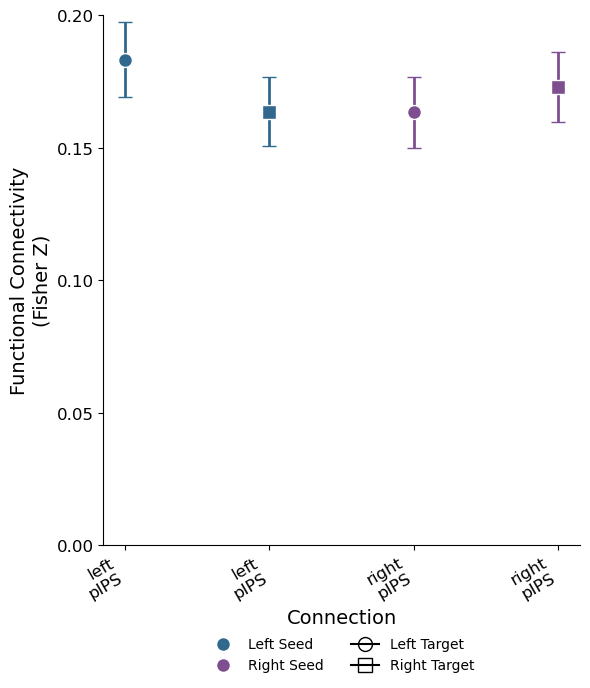

In [ ]:
# plot fc data exp 1
import matplotlib.pyplot as plt
import numpy as np

def create_fc_plot(fc_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space at bottom for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = fc_data[
                (fc_data['seed_hemisphere'] == seed_hemi) &
                (fc_data['target_hemisphere'] == target_hemi)
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=5, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Functional Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    
    # Set y-axis minimum to 0 and fewer ticks
    ax.set_ylim(bottom=0, top=0.2)
    ax.set_yticks(np.arange(0, 0.21, 0.05))  # Set ticks at 0, 0.05, 0.10, 0.15, 0.20
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_fc_plot(fc_data)
plt.show()

In [ ]:
# PPI Analysis - test significance greater than 0 || need to update exp 1 subject number 
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor
import warnings
warnings.filterwarnings('ignore')

# Directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
output_dir = f'{curr_dir}/tools'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def calculate_effect_size(data):
    """Calculate Cohen's d"""
    return np.mean(data) / np.std(data) if len(data) > 0 else np.nan

def run_stats_analysis(df, value_col='value'):
    """Run Wilcoxon test and calculate effect size"""
    w_stat, p_val = stats.wilcoxon(df[value_col])
    d = calculate_effect_size(df[value_col])
    return pd.Series({
        'W': w_stat,
        'p': p_val,
        'd': d,
        'mean': np.mean(df[value_col]),
        'sem': stats.sem(df[value_col])
    })

# Load data
exp1_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition labels for Exp2
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'
exp2_df = pd.concat([tools_df, nontools_df])

def analyze_experiment(df, seed_rois, target_rois, exp_num):
    results = []
    hemispheres = ['left', 'right']
    
    for seed in seed_rois:
        for seed_hemi in hemispheres:
            for target in target_rois:
                for target_hemi in hemispheres:
                    if exp_num == 1:
                        subset = df[
                            (df['seed_roi'] == seed) & 
                            (df['seed_hemisphere'] == seed_hemi) &
                            (df['target_roi'] == target) &
                            (df['target_hemisphere'] == target_hemi) &
                            (df['analysis'] == 'ppi')
                        ]
                        if len(subset) > 0:
                            stats = run_stats_analysis(subset, value_col='mean_activation')
                            results.append({
                                'seed': f"{seed}_{seed_hemi}",
                                'target': f"{target}_{target_hemi}",
                                **stats
                            })
                    else:
                        for condition in df['condition'].unique():
                            subset = df[
                                (df['seed_roi'] == seed) & 
                                (df['seed_hemi'] == seed_hemi) &
                                (df['target_roi'] == target) &
                                (df['target_hemi'] == target_hemi) &
                                (df['condition'] == condition)
                            ]
                            if len(subset) > 0:
                                stats = run_stats_analysis(subset)
                                results.append({
                                    'seed': f"{seed}_{seed_hemi}",
                                    'target': f"{target}_{target_hemi}",
                                    'condition': condition,
                                    **stats
                                })
    return pd.DataFrame(results)

# Run analyses
exp1_results = analyze_experiment(exp1_df, ['pIPS'], ['LO'], 1)
exp2_results = analyze_experiment(exp2_df, ['pIPS', 'aIPS'], ['LO'], 2)

# Apply FDR correction
for results_df in [exp1_results, exp2_results]:
    if not results_df.empty and 'p' in results_df.columns:
        p_values = results_df['p'].values
        rejected, fdr_corrected = fdrcorrection(p_values)
        results_df['p_fdr'] = fdr_corrected

# Print and save results
print("\nExperiment 1 Results:")
print(exp1_results.round(3).to_string())
print("\nExperiment 2 Results:")
print(exp2_results.round(3).to_string())

# Save detailed results
exp1_results.to_csv(f"{results_dir}/exp1_ppi_stats.csv", index=False)
exp2_results.to_csv(f"{output_dir}/exp2_ppi_stats.csv", index=False)

# Save summary for manuscript
with open(f"{results_dir}/ppi_stats_summary.txt", 'w') as f:
    f.write("Experiment 1 (Object vs Scramble) PPI Results:\n")
    for _, row in exp1_results.iterrows():
        f.write(f"\n{row['seed']} -> {row['target']}\n")
        f.write(f"W = {row['W']:.0f}, p = {row['p']:.3f} (FDR p = {row['p_fdr']:.3f}), d = {row['d']:.2f}\n")
        f.write(f"Mean ± SEM: {row['mean']:.3f} ± {row['sem']:.3f}\n")
    
    f.write("\n\nExperiment 2 (Tools vs Nontools) PPI Results:\n")
    for _, row in exp2_results.iterrows():
        f.write(f"\n{row['seed']} -> {row['target']} ({row['condition']})\n")
        f.write(f"W = {row['W']:.0f}, p = {row['p']:.3f} (FDR p = {row['p_fdr']:.3f}), d = {row['d']:.2f}\n")
        f.write(f"Mean ± SEM: {row['mean']:.3f} ± {row['sem']:.3f}\n")


Experiment 1 Results:
         seed    target       W      p      d   mean    sem  p_fdr
0   pIPS_left   LO_left  3.0000 0.0000 1.3400 0.0350 0.0060 0.0000
1   pIPS_left  LO_right 12.0000 0.0000 1.1560 0.0310 0.0060 0.0000
2  pIPS_right   LO_left 13.0000 0.0000 1.1370 0.0280 0.0060 0.0000
3  pIPS_right  LO_right 20.0000 0.0010 1.0040 0.0230 0.0050 0.0010

Experiment 2 Results:
          seed    target condition        W      p       d    mean    sem  p_fdr
0    pIPS_left   LO_left     Tools 154.0000 0.0040  0.5570  0.0190 0.0060 0.0220
1    pIPS_left   LO_left  Nontools 253.0000 0.2140  0.1970  0.0060 0.0050 0.2860
2    pIPS_left  LO_right     Tools 166.0000 0.0080  0.5260  0.0180 0.0060 0.0250
3    pIPS_left  LO_right  Nontools 248.0000 0.1870  0.2180  0.0070 0.0050 0.2860
4   pIPS_right   LO_left     Tools 152.0000 0.0040  0.5300  0.0170 0.0060 0.0220
5   pIPS_right   LO_left  Nontools 233.0000 0.1190  0.2560  0.0100 0.0060 0.2110
6   pIPS_right  LO_right     Tools 212.0000 0.0580  

In [62]:
# PPI Stats Match FC
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')

# Directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load data
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
ppi_data = data_df[data_df['analysis'] == 'ppi']

def analyze_hemispheric_patterns(data):
    """Analyze hemispheric connectivity patterns in the data"""
    results = {}
    
    # Separate ipsilateral and contralateral connections
    ipsi_mask = ((data['seed_hemisphere'] == 'left') & (data['target_hemisphere'] == 'left')) | \
                ((data['seed_hemisphere'] == 'right') & (data['target_hemisphere'] == 'right'))
    
    ipsi = data[ipsi_mask]['mean_activation']
    contra = data[~ipsi_mask]['mean_activation']
    
    # Ipsilateral vs Contralateral comparison
    w_stat_ipsi, p_val_ipsi = stats.wilcoxon(ipsi, contra)
    diff = ipsi.values - contra.values
    d_ipsi = np.mean(diff) / (np.std(diff, ddof=1) + 1e-10)
    
    results['ipsi_contra'] = {
        'W': w_stat_ipsi,
        'p': p_val_ipsi,
        'd': d_ipsi,
        'ipsi_mean': np.mean(ipsi),
        'ipsi_sem': stats.sem(ipsi),
        'contra_mean': np.mean(contra),
        'contra_sem': stats.sem(contra)
    }
    
    # Left vs Right pIPS seeds
    left_pips = data[data['seed_hemisphere'] == 'left']['mean_activation']
    right_pips = data[data['seed_hemisphere'] == 'right']['mean_activation']
    w_stat_seed, p_val_seed = stats.wilcoxon(left_pips, right_pips)
    d_seed = (np.mean(left_pips) - np.mean(right_pips)) / \
             (np.sqrt((np.var(left_pips, ddof=1) + np.var(right_pips, ddof=1)) / 2) + 1e-10)
    
    results['seeds'] = {
        'W': w_stat_seed,
        'p': p_val_seed,
        'd': d_seed,
        'left_mean': np.mean(left_pips),
        'left_sem': stats.sem(left_pips),
        'right_mean': np.mean(right_pips),
        'right_sem': stats.sem(right_pips)
    }
    
    # Left vs Right LO targets
    left_lo = data[data['target_hemisphere'] == 'left']['mean_activation']
    right_lo = data[data['target_hemisphere'] == 'right']['mean_activation']
    w_stat_target, p_val_target = stats.wilcoxon(left_lo, right_lo)
    d_target = (np.mean(left_lo) - np.mean(right_lo)) / \
               (np.sqrt((np.var(left_lo, ddof=1) + np.var(right_lo, ddof=1)) / 2) + 1e-10)
    
    results['targets'] = {
        'W': w_stat_target,
        'p': p_val_target,
        'd': d_target,
        'left_mean': np.mean(left_lo),
        'left_sem': stats.sem(left_lo),
        'right_mean': np.mean(right_lo),
        'right_sem': stats.sem(right_lo)
    }
    
    return results

# Run the analysis
results = analyze_hemispheric_patterns(ppi_data)

# Apply FDR correction
p_values = [results['ipsi_contra']['p'], 
            results['seeds']['p'], 
            results['targets']['p']]
_, p_values_corrected = fdrcorrection(p_values)

# Save detailed results to a text file
with open(f"{results_dir}/ppi_hemisphere_analysis.txt", 'w') as f:
    f.write("PPI Hemispheric Connectivity Analysis Results:\n\n")
    
    # Ipsilateral vs Contralateral
    r = results['ipsi_contra']
    f.write("Ipsilateral vs Contralateral Connections:\n")
    f.write(f"W = {r['W']:.1f}, p = {r['p']:.3f} (FDR-corrected p = {p_values_corrected[0]:.3f}), d = {r['d']:.3f}\n")
    f.write(f"Ipsilateral: {r['ipsi_mean']:.3f} ± {r['ipsi_sem']:.3f}\n")
    f.write(f"Contralateral: {r['contra_mean']:.3f} ± {r['contra_sem']:.3f}\n\n")
    
    # Seeds comparison
    r = results['seeds']
    f.write("Left vs Right pIPS Seeds:\n")
    f.write(f"W = {r['W']:.1f}, p = {r['p']:.3f} (FDR-corrected p = {p_values_corrected[1]:.3f}), d = {r['d']:.3f}\n")
    f.write(f"Left pIPS: {r['left_mean']:.3f} ± {r['left_sem']:.3f}\n")
    f.write(f"Right pIPS: {r['right_mean']:.3f} ± {r['right_sem']:.3f}\n\n")
    
    # Targets comparison
    r = results['targets']
    f.write("Left vs Right LO Targets:\n")
    f.write(f"W = {r['W']:.1f}, p = {r['p']:.3f} (FDR-corrected p = {p_values_corrected[2]:.3f}), d = {r['d']:.3f}\n")
    f.write(f"Left LO: {r['left_mean']:.3f} ± {r['left_sem']:.3f}\n")
    f.write(f"Right LO: {r['right_mean']:.3f} ± {r['right_sem']:.3f}\n")

# Print results to console
print("\nResults saved to:", f"{results_dir}/ppi_hemisphere_analysis.txt")


Results saved to: /user_data/csimmon2/git_repos/ptoc/results/ppi_hemisphere_analysis.txt


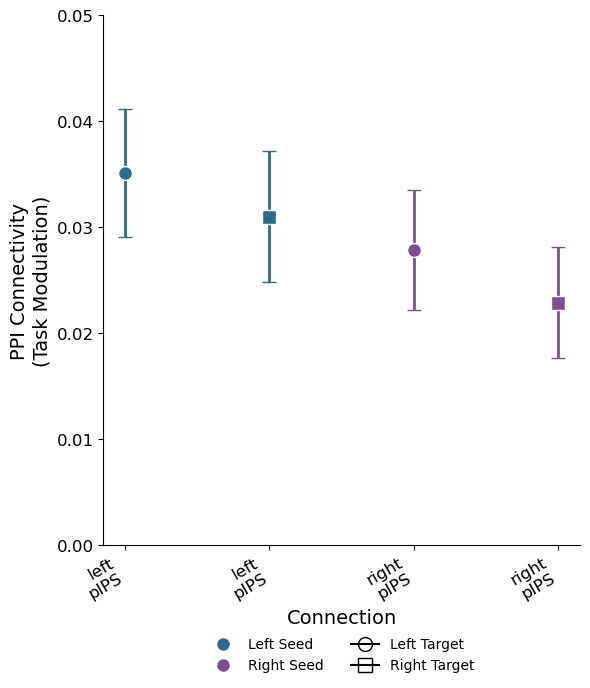

In [63]:
#  plot ppi results exp 1import matplotlib.pyplot as plt
## at some point add singificant astericks to the plot
import numpy as np

def create_ppi_plot(ppi_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = ppi_data[
                (ppi_data['seed_hemisphere'] == seed_hemi) &
                (ppi_data['target_hemisphere'] == target_hemi) &
                (ppi_data['analysis'] == 'ppi')
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=5, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('PPI Connectivity\n(Task Modulation)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    
    # Set y-axis scale with tighter limits
    # Add just a bit of padding above and below the data
    data_range = max(means) - min(means)
    padding = data_range * 0.1  # 10% padding
    ymin = max(-0.05, min(means) - padding)  # Don't go below -0.05 if data doesn't warrant it
    ymax = max(means) + padding
    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(np.floor(ymin*20)/20, ymax+0.02, 0.01))  # Ticks every 0.05
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_ppi_plot(data_df)
plt.show()

GCA

In [56]:
## exp 1 GCA - univariate analysis with correction [this is essentially non-parametric t-tests]

import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

# Read the existing summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Apply FDR correction
p_values = summary_table_combined['p_value'].values
rejected, p_corrected = fdrcorrection(p_values, alpha=0.05, method='indep')

# Update table with FDR results
summary_table_combined['p_value_fdr'] = p_corrected
summary_table_combined['significant_fdr'] = rejected

# Save updated results
summary_table_combined.to_csv(f"{fig_dir}/gca_summary_table_combined_fdr.csv", index=False)

# Load t-test results from text file
with open(f"{fig_dir}/gca_roi_pair_combined_comparison_results.txt", 'r') as f:
    lines = f.readlines()

# Extract p-values (assuming they're in the same order as your original script)
t_test_pvals = []
for line in lines:
    if line.startswith('p-value:'):
        t_test_pvals.append(float(line.split(': ')[1].strip()))

# Apply FDR to t-tests
rejected_t, p_corrected_t = fdrcorrection(t_test_pvals, alpha=0.05, method='indep')

# Update and display results
summary_table_combined['p_value_fdr'] = p_corrected
summary_table_combined['significant_fdr'] = rejected
print("\nAfter FDR correction:")
print(summary_table_combined)

# Save FDR-corrected t-test results
with open(f"{fig_dir}/gca_roi_pair_combined_comparison_results_fdr.txt", 'w') as f:
    f.write("FDR-corrected p-values for paired t-tests:\n\n")
    f.write(f"lpIPS-lLO vs rpIPS-lLO (Object): p_fdr = {p_corrected_t[0]:.4f}\n")
    f.write(f"lpIPS-rLO vs rpIPS-rLO (Object): p_fdr = {p_corrected_t[1]:.4f}\n")
    f.write(f"lpIPS-lLO vs rpIPS-lLO (Scramble): p_fdr = {p_corrected_t[2]:.4f}\n")
    f.write(f"lpIPS-rLO vs rpIPS-rLO (Scramble): p_fdr = {p_corrected_t[3]:.4f}\n")


After FDR correction:
  origin target condition  Mean f_diff  Std f_diff  W_statistic  p_value  \
0  lpIPS    lLO    Object         7.71       11.70         21.0  0.00169   
1  lpIPS    rLO    Object         7.49        9.01         10.0  0.00016   
2  rpIPS    lLO    Object         1.82        8.12         61.0  0.18187   
3  rpIPS    rLO    Object         1.58        9.33         66.0  0.25793   
4  lpIPS    lLO  Scramble         1.05        3.73         71.0  0.35246   
5  lpIPS    rLO  Scramble         0.82        6.17         65.0  0.24125   
6  rpIPS    lLO  Scramble         0.63        5.05         89.0  0.82878   
7  rpIPS    rLO  Scramble         0.79        4.10         79.0  0.54122   

   Effect size  significant  p_value_fdr  significant_fdr  
0         0.93         True     0.006760             True  
1         1.18         True     0.001280             True  
2         0.32        False     0.412688            False  
3         0.24        False     0.412688            

In [ ]:
# exp 1 - extract gca summary [this is attempting an ANOVA on the GCA values]
import nibabel as nib
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import pingouin as pg

# Base paths
base_path = '/lab_data/behrmannlab/vlad/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'


### need to add hemisphere as the initial script excluded the variable.
def extract_roi_values(sub_id, roi, hemi, condition='object'):
    """Extract GCA values from ROI nifti"""
    filepath = f'{base_path}/sub-{sub_id}/ses-01/derivatives/gca/combined_{condition}_{roi}_{hemi}_mni.nii.gz'
    
    # Check if the file exists before trying to load it
    if not os.path.exists(filepath):
        print(f"Warning: File {filepath} does not exist for subject {sub_id}, ROI {roi}, hemisphere {hemi}, condition {condition}. Skipping...")
        return None  # Or return a default value if needed, like 0 or np.nan
    
    # If file exists, load it
    img = nib.load(filepath)
    return np.mean(img.get_fdata())  # Or other extraction method


def calculate_effect_size(data):
    """Calculate r effect size from Wilcoxon test"""
    return np.abs(stats.wilcoxon(data)[0]) / np.sqrt(len(data) * 2)

def analyze_gca(subjects, rois=['pIPS_left', 'pIPS_right'], targets=['LO_left', 'LO_right']):
    results = []
    data_for_anova = []
    
    # Extract values and run tests
    for roi in rois:
        for target in targets:
            values = []
            for sub in subjects:
                roi_val = extract_roi_values(sub, roi)
                values.append(roi_val)
                
                # Store for ANOVA
                data_for_anova.append({
                    'subject': sub,
                    'ROI': roi.split('_')[0],
                    'hemisphere': roi.split('_')[1],
                    'target': target,
                    'value': roi_val
                })
            
            # Wilcoxon test against 0
            w_stat, p_val = stats.wilcoxon(values)
            effect_r = calculate_effect_size(values)
            
            results.append({
                'seed': roi,
                'target': target,
                'W': w_stat,
                'p': p_val,
                'r': effect_r,
                'mean': np.mean(values),
                'sem': stats.sem(values)
            })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # FDR correction
    _, fdr_corrected = fdrcorrection(results_df['p'])
    results_df['p_fdr'] = fdr_corrected
    
    # ANOVA
    anova_df = pd.DataFrame(data_for_anova)
    aov = pg.rm_anova(data=anova_df,
                      dv='value',
                      within=['ROI', 'hemisphere'],
                      subject='subject')
    
    return results_df, aov

# Get subject list
subjects = [sub.replace('sub-', '') for sub in os.listdir(base_path) if sub.startswith('sub-')]

# Run analysis
results, anova = analyze_gca(subjects)

# Save results
results.to_csv(f"{results_dir}/gca_stats.csv", index=False)
anova.to_csv(f"{results_dir}/gca_anova.csv", index=False)

# Print formatted results
print("\nGCA Results:")
print(results.round(3).to_string())
print("\nANOVA Results:")
print(anova.round(3).to_string())

TypeError: extract_roi_values() missing 1 required positional argument: 'hemi'